In [1]:
bs = 256
lr = 0.1
epochs = 20

In [2]:
from torchvision.transforms import ToTensor, Lambda
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn
import torch


train_ds = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

valid_ds = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
train_ds.__getitem__(0)[0].shape

torch.Size([1, 28, 28])

9


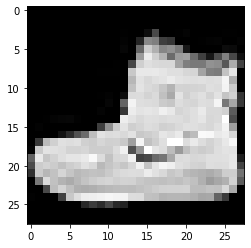

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(train_ds.__getitem__(0)[0].reshape((28, 28)), cmap="gray")
print(train_ds.__getitem__(0)[1])

In [5]:
def accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
    model.train()
    return "%.2f" % float(num_correct/num_samples*100)

In [6]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [7]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    
        print(epoch, ": loss:" , val_loss, " accuracy:", accuracy(valid_dl, model))

In [8]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [9]:


class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [10]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [11]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [12]:
from torch import optim
import torch.nn.functional as F

loss_func = F.cross_entropy

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

modelCNN = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
).to(dev)

modelMLP = NeuralNetwork().to(dev)

optCNN = optim.SGD(modelCNN.parameters(), lr=lr, momentum=0.9)
optMLP = optim.SGD(modelMLP.parameters(), lr=lr, momentum=0.9)

In [13]:
model_parameters = filter(lambda p: p.requires_grad, modelCNN.parameters())
paramsCNN = sum([np.prod(p.size()) for p in model_parameters])

In [14]:
model_parameters = filter(lambda p: p.requires_grad, modelMLP.parameters())
paramsMLP = sum([np.prod(p.size()) for p in model_parameters])

In [15]:
import time

start = time.time()
print("CNN model with ", paramsCNN, " parameters")
fit(epochs, modelCNN, loss_func, optCNN, train_dl, valid_dl)
print("CNN model done in ", (time.time() - start) ,"!")

CNN model with  3930  parameters
0 : loss: 0.8227554174423217  accuracy: 70.67
1 : loss: 0.8101805722236634  accuracy: 68.37
2 : loss: 0.5545409452438355  accuracy: 80.44
3 : loss: 0.545606254196167  accuracy: 80.95
4 : loss: 0.5012012807846069  accuracy: 82.25
5 : loss: 0.5087609139442444  accuracy: 82.19
6 : loss: 0.4938959129333496  accuracy: 82.08
7 : loss: 0.4733497972011566  accuracy: 82.75
8 : loss: 0.4626844910144806  accuracy: 83.11
9 : loss: 0.47577910652160643  accuracy: 83.24
10 : loss: 0.44047205238342285  accuracy: 83.94
11 : loss: 0.4327656965732574  accuracy: 84.41
12 : loss: 0.4345072291374207  accuracy: 84.37
13 : loss: 0.41947286434173586  accuracy: 84.84
14 : loss: 0.43103913011550904  accuracy: 84.62
15 : loss: 0.4263362976551056  accuracy: 84.46
16 : loss: 0.43572401161193847  accuracy: 84.17
17 : loss: 0.42769895195961  accuracy: 84.52
18 : loss: 0.4082241670131683  accuracy: 85.14
19 : loss: 0.4169861696243286  accuracy: 84.56
CNN model done in  56.1253821849823

In [16]:
import time
start = time.time()
print("MLP model with ", paramsMLP, " parameters")
fit(epochs, modelMLP, loss_func, optMLP, train_dl, valid_dl)
print("MLP model done in ", (time.time() - start) ,"!")

MLP model with  669706  parameters
0 : loss: 0.48072985439300536  accuracy: 82.42
1 : loss: 0.41261579413414  accuracy: 85.12
2 : loss: 0.40197105627059937  accuracy: 85.63
3 : loss: 0.3517398661136627  accuracy: 87.34
4 : loss: 0.36066475949287413  accuracy: 86.77
5 : loss: 0.3631916656494141  accuracy: 86.46
6 : loss: 0.3361935196638107  accuracy: 88.07
7 : loss: 0.3552147439956665  accuracy: 86.75
8 : loss: 0.3369646210193634  accuracy: 87.34
9 : loss: 0.3351933843612671  accuracy: 87.68
10 : loss: 0.3275769112110138  accuracy: 88.31
11 : loss: 0.36772255415916444  accuracy: 86.94
12 : loss: 0.35388381757736204  accuracy: 87.44
13 : loss: 0.324196900177002  accuracy: 88.82
14 : loss: 0.32726354475021363  accuracy: 88.88
15 : loss: 0.3264715483665466  accuracy: 89.29
16 : loss: 0.34352032742500305  accuracy: 88.87
17 : loss: 0.3383156363964081  accuracy: 88.67
18 : loss: 0.3325764519453049  accuracy: 88.29
19 : loss: 0.33909751195907595  accuracy: 88.89
MLP model done in  54.27402734